In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/35.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/31.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/33.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/14.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/20.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/18.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/21.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/12.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/28.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/22.png
/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/validation/2/507/images/34.png
/kaggle/in

In [4]:
import numpy as np
np.random.seed(42) 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [5]:
num_classes = len(os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'))

In [6]:
# Custom Dataset Class


class LiverDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, _, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = class_names.index(label)  # Convert label to index
        return image, label_idx

# Get Class Names from Train Directory
class_names = os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train')


In [7]:
train_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'
training_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            training_data.append([image_path, patient, label])

In [8]:
test_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
testing_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            testing_data.append([image_path, patient, label])



In [9]:
valid_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
validation_data = []

for label in os.listdir(valid_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        valid_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            validation_data.append([image_path, patient, label])

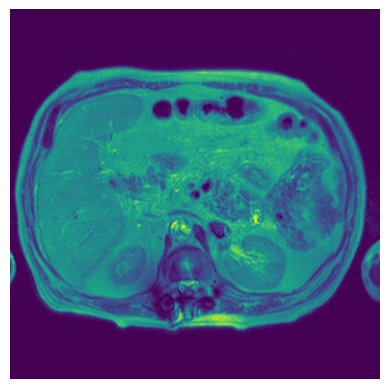

In [10]:
image_path = training_data[0][0]
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [11]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomRotation(degrees=5),  # Rotate image by ±5 degrees
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [12]:
train_dataset = LiverDiseaseDataset(training_data, transform=data_transforms['train'])
val_dataset = LiverDiseaseDataset(validation_data, transform=data_transforms['val'])
test_dataset = LiverDiseaseDataset(testing_data, transform=data_transforms['test'])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load EfficientNet (e.g., efficientnet_b0)
num_classes = 3
efficientnet = models.efficientnet_b0(pretrained=True)

# Replace the classifier head
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to device
efficientnet = efficientnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 94.7MB/s]


Epoch 1 | train Loss: 0.8084, Acc: 0.6148
Epoch 1 | val Loss: 1.9200, Acc: 0.5161
Epoch 2 | train Loss: 0.4133, Acc: 0.8428
Epoch 2 | val Loss: 2.9676, Acc: 0.5161
Epoch 3 | train Loss: 0.2170, Acc: 0.9199
Epoch 3 | val Loss: 3.9195, Acc: 0.4782
Epoch 4 | train Loss: 0.1331, Acc: 0.9509
Epoch 4 | val Loss: 3.6681, Acc: 0.4972
Epoch 5 | train Loss: 0.0970, Acc: 0.9663
Epoch 5 | val Loss: 4.3448, Acc: 0.5161
Epoch 6 | train Loss: 0.0746, Acc: 0.9776
Epoch 6 | val Loss: 3.8107, Acc: 0.5161
Epoch 7 | train Loss: 0.0476, Acc: 0.9855
Epoch 7 | val Loss: 4.0550, Acc: 0.5161
Epoch 8 | train Loss: 0.0591, Acc: 0.9833
Epoch 8 | val Loss: 3.7458, Acc: 0.5161
Epoch 9 | train Loss: 0.0545, Acc: 0.9831
Epoch 9 | val Loss: 3.8782, Acc: 0.5161
Epoch 10 | train Loss: 0.0455, Acc: 0.9868
Epoch 10 | val Loss: 3.9734, Acc: 0.5161
Epoch 11 | train Loss: 0.0456, Acc: 0.9880
Epoch 11 | val Loss: 4.1103, Acc: 0.5161
Epoch 12 | train Loss: 0.0409, Acc: 0.9895
Epoch 12 | val Loss: 4.1605, Acc: 0.5161
Epoch 13 |

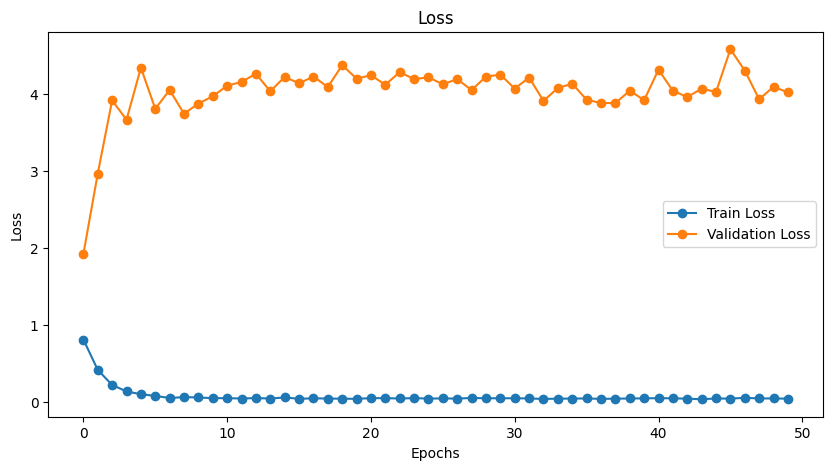

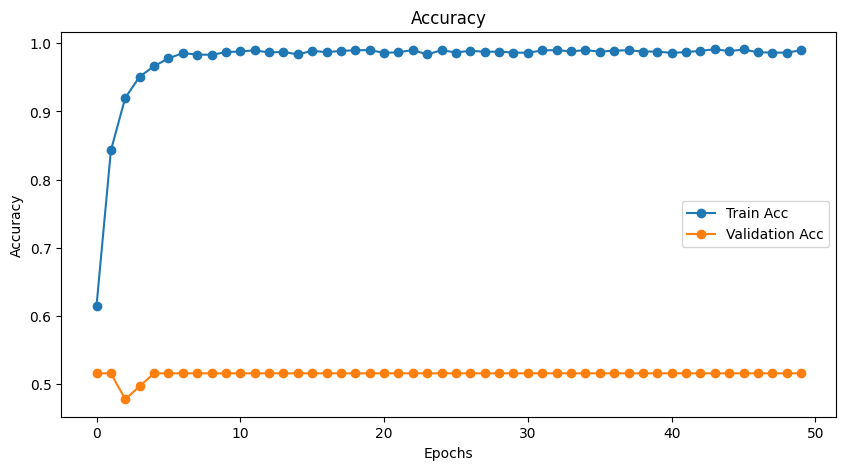

In [16]:
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=1e-4)

# Add a learning rate scheduler (StepLR with step size of 5 epochs and gamma=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 50
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            efficientnet.train()
            dataloader = train_loader
        else:
            efficientnet.eval()
            dataloader = val_loader

        running_loss, correct = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = efficientnet(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    
    # Step the scheduler after each epoch
    scheduler.step()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss'), plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy'), plt.legend()
plt.show()


Test Accuracy: 55.42%

Class-wise Metrics:
2:
  Precision: 0.21
  Recall: 0.41
  F1-Score: 0.28
  Specificity: 0.61
3:
  Precision: 0.66
  Recall: 0.57
  F1-Score: 0.61
  Specificity: 0.89
1:
  Precision: 0.85
  Recall: 0.60
  F1-Score: 0.70
  Specificity: 0.89

Overall Metrics:
  Precision: 0.57
  Recall: 0.53
  F1-Score: 0.53
  Specificity: 0.80

Classification Report:
              precision    recall  f1-score   support

           2       0.21      0.41      0.28       133
           3       0.66      0.57      0.61       181
           1       0.85      0.60      0.70       350

    accuracy                           0.55       664
   macro avg       0.57      0.53      0.53       664
weighted avg       0.67      0.55      0.59       664



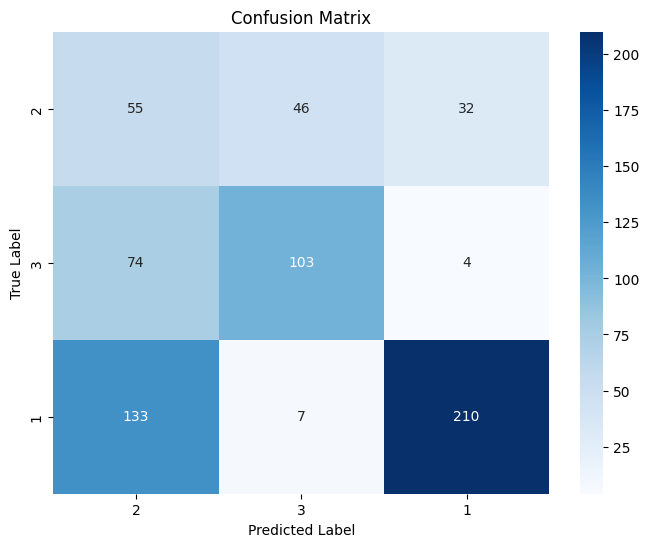

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
)

# Ensure model is in evaluation mode
efficientnet.eval()

# Store true and predicted labels
y_true = []
y_pred = []

# Run model on test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Use your test data loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = efficientnet(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute class-wise precision, recall, f1-score, and support
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Compute specificity for each class
specificity = []
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True Negatives
    fp = cm[:, i].sum() - cm[i, i]  # False Positives
    specificity.append(tn / (tn + fp))

# Compute overall precision, recall, and f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# Compute overall specificity
overall_specificity = np.mean(specificity)

# Display class-wise metrics
print("\nClass-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Specificity: {specificity[i]:.2f}")

# Print overall metrics
print("\nOverall Metrics:")
print(f"  Precision: {overall_precision:.2f}")
print(f"  Recall: {overall_recall:.2f}")
print(f"  F1-Score: {overall_f1:.2f}")
print(f"  Specificity: {overall_specificity:.2f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
